In [ ]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


In [ ]:
# !pip install tensorflowjs

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define the path to the uploaded zip file and the extraction directory
zip_file_path = '/content/drive/MyDrive/Submission Dicoding/RiceLeafsDisease.zip'
extraction_dir = 'RiceLeafsDisease/'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

# List the extracted files to understand the contents
extracted_files = os.listdir(extraction_dir)
extracted_files

['RiceLeafsDisease']

In [ ]:
# List the contents of the train and validation directories
train_dir = os.path.join(extraction_dir, '/content/RiceLeafsDisease/RiceLeafsDisease/train')
validation_dir = os.path.join(extraction_dir, '/content/RiceLeafsDisease/RiceLeafsDisease/validation')

train_contents = os.listdir(train_dir)
validation_contents = os.listdir(validation_dir)

train_contents, validation_contents


(['leaf_blast',
  'bacterial_leaf_blight',
  'healthy',
  'leaf_brown_spot',
  'leaf_scald'],
 ['leaf_blast',
  'bacterial_leaf_blight',
  'healthy',
  'leaf_brown_spot',
  'leaf_scald'])

In [ ]:
# Function to count files in each class directory
def count_files_in_dir(directory):
    return {class_dir: len(os.listdir(os.path.join(directory, class_dir))) for class_dir in os.listdir(directory)}

# Count files in each class directory in train and validation
train_file_counts = count_files_in_dir(train_dir)
validation_file_counts = count_files_in_dir(validation_dir)

train_file_counts, validation_file_counts

({'leaf_blast': 350,
  'bacterial_leaf_blight': 350,
  'healthy': 350,
  'leaf_brown_spot': 350,
  'leaf_scald': 350},
 {'leaf_blast': 88,
  'bacterial_leaf_blight': 88,
  'healthy': 88,
  'leaf_brown_spot': 88,
  'leaf_scald': 88})

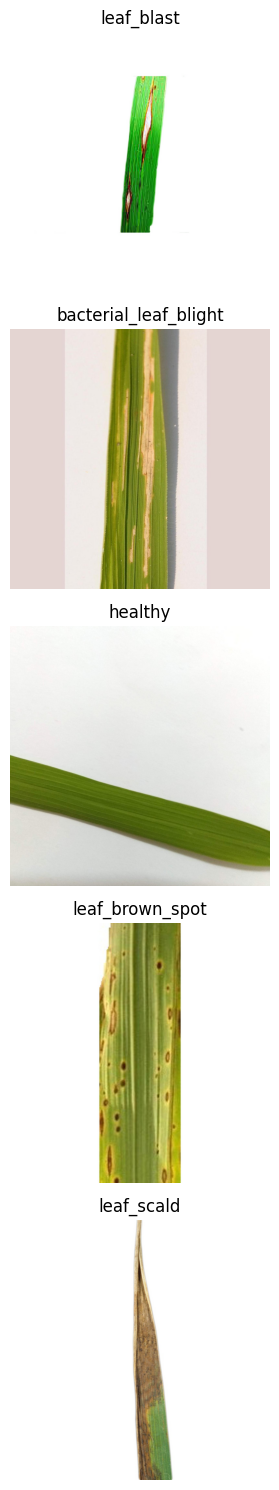

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Function to display a sample image from each class directory
def display_sample_images(directory, class_names, num_samples=1):
    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(num_samples * 3, len(class_names) * 3))
    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        sample_files = os.listdir(class_dir)[:num_samples]
        for j, file in enumerate(sample_files):
            img_path = os.path.join(class_dir, file)
            img = mpimg.imread(img_path)
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(class_name)
    plt.tight_layout()
    plt.show()

# Display sample images from the training set
display_sample_images(train_dir, train_contents)

In [ ]:
train_dir = 'RiceLeafsDisease/RiceLeafsDisease/train'
validation_dir = 'RiceLeafsDisease/RiceLeafsDisease/validation'

In [ ]:
img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True
      )

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 1750 images belonging to 5 classes.
Found 440 images belonging to 5 classes.


In [ ]:
# Display classes and their corresponding labels from the train generator
print("Class indices in training data:")
for class_name, label in train_generator.class_indices.items():
    print(f"Class: {class_name}, Label: {label}")

# Display classes and their corresponding labels from the validation generator
print("\nClass indices in validation data:")
for class_name, label in validation_generator.class_indices.items():
    print(f"Class: {class_name}, Label: {label}")


Class indices in training data:
Class: bacterial_leaf_blight, Label: 0
Class: healthy, Label: 1
Class: leaf_blast, Label: 2
Class: leaf_brown_spot, Label: 3
Class: leaf_scald, Label: 4

Class indices in validation data:
Class: bacterial_leaf_blight, Label: 0
Class: healthy, Label: 1
Class: leaf_blast, Label: 2
Class: leaf_brown_spot, Label: 3
Class: leaf_scald, Label: 4


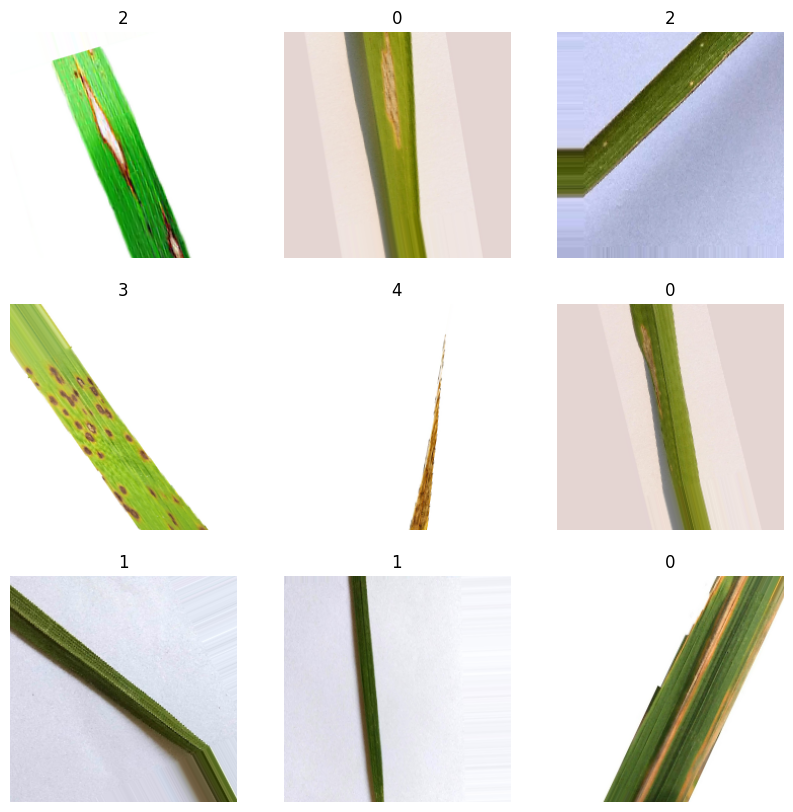

In [ ]:
# Visualize some images from the training set
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_batch[i])
    plt.title(np.argmax(y_batch[i]))
    plt.axis('off')
plt.show()

In [ ]:
import tensorflow as tf
# Membuat model dasar (base model) dari pre-trained model MobileNet
base_model = tf.keras.applications.MobileNet(input_shape=(224, 224, 3),
                                              include_top=False,
                                              weights='imagenet')

17225924/17225924 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [ ]:
model = tf.keras.models.Sequential([
    # This is the first convolution
    base_model,
    # The second convolution
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    # The third convolution
    tf.keras.layers.Conv2D(128,3, activation='relu'),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 64)          589888    
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 128)         147584    
                                                                 
 global_average_pooling2d (  (None, 128)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               6

In [ ]:
# Set the training parameters
import tensorflow as tf
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-04)
model.compile(loss = 'categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the ModelCheckpoint callback to save the model when the validation accuracy improves
checkpoint = ModelCheckpoint(
    'best_model.h5',          # Path where the model will be saved
    monitor='val_accuracy',   # Monitor validation accuracy
    save_best_only=True,      # Save only the best model
    mode='max',               # Mode to save the model with maximum validation accuracy
    verbose=1                 # Verbosity mode, 1 = messages displayed when saving
)

# Define the EarlyStopping callback to stop training when the model stops improving
early_stopping = EarlyStopping(
    monitor='val_accuracy',   # Monitor validation accuracy
    mode='max',               # Mode to stop training when there is no improvement
    patience=5,               # Number of epochs with no improvement after which training will be stopped
    verbose=1                 # Verbosity mode, 1 = messages displayed when stopping
)

In [ ]:
# Train the model with the callbacks
his = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping]  # Add the callbacks here
)

Epoch 1/30
55/55 [==============================] - ETA: 0s - loss: 1.2146 - accuracy: 0.6251
Epoch 1: val_accuracy improved from -inf to 0.75682, saving model to best_model.h5
55/55 [==============================] - 52s 801ms/step - loss: 1.2146 - accuracy: 0.6251 - val_loss: 0.7499 - val_accuracy: 0.7568
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


55/55 [==============================] - ETA: 0s - loss: 0.6534 - accuracy: 0.8331
Epoch 2: val_accuracy improved from 0.75682 to 0.77273, saving model to best_model.h5
55/55 [==============================] - 42s 772ms/step - loss: 0.6534 - accuracy: 0.8331 - val_loss: 0.7090 - val_accuracy: 0.7727
Epoch 3/30
55/55 [==============================] - ETA: 0s - loss: 0.5714 - accuracy: 0.8469
Epoch 3: val_accuracy improved from 0.77273 to 0.85455, saving model to best_model.h5
55/55 [==============================] - 43s 782ms/step - loss: 0.5714 - accuracy: 0.8469 - val_loss: 0.5571 - val_accuracy: 0.8545
Epoch 4/30
55/55 [==============================] - ETA: 0s - loss: 0.4813 - accuracy: 0.8920
Epoch 4: val_accuracy improved from 0.85455 to 0.89545, saving model to best_model.h5
55/55 [==============================] - 42s 764ms/step - loss: 0.4813 - accuracy: 0.8920 - val_loss: 0.4750 - val_accuracy: 0.8955
Epoch 5/30
55/55 [==============================] - ETA: 0s - loss: 0.4731 

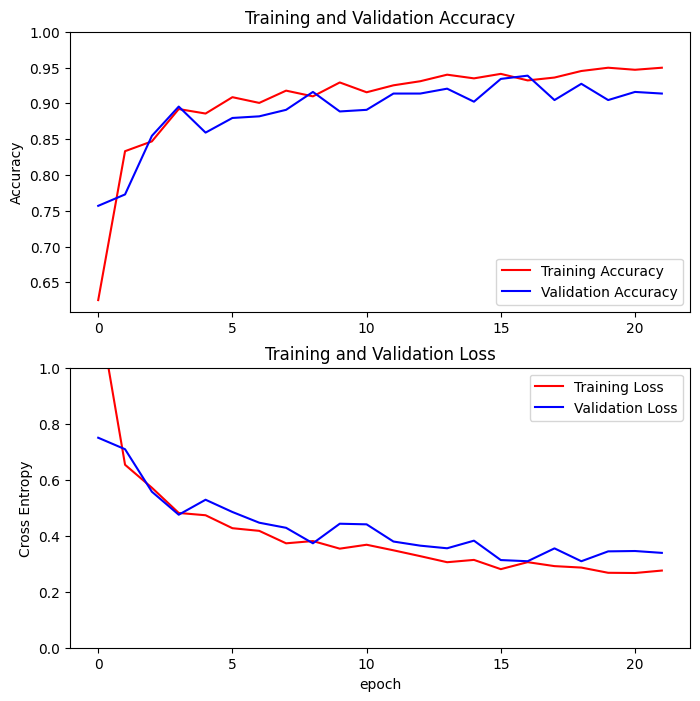

In [ ]:
acc = his.history['accuracy']
val_acc = his.history['val_accuracy']

loss = his.history['loss']
val_loss = his.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, 'r', label='Training Accuracy')
plt.plot(val_acc, 'b', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, 'r', label='Training Loss')
plt.plot(val_loss, 'b', label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

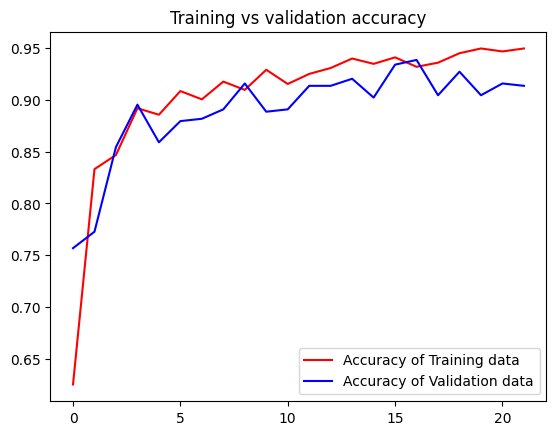

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
get_acc = his.history['accuracy']
value_acc = his.history['val_accuracy']
get_loss = his.history['loss']
validation_loss = his.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

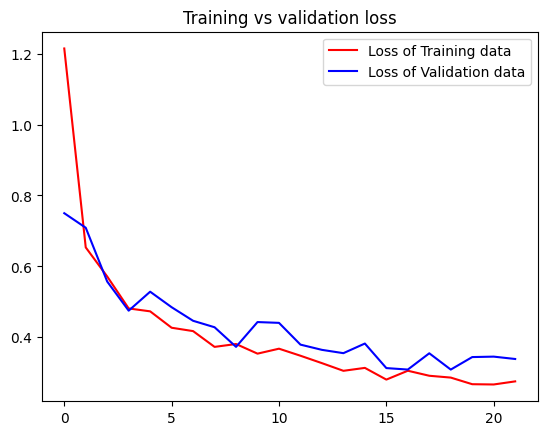

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

1/1 [==============================] - 1s 1s/step


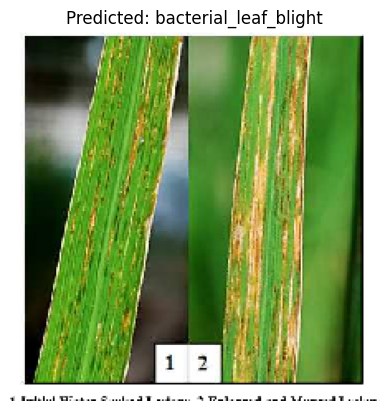

In [ ]:
# Ensure you have TensorFlow installed
# pip install tensorflow

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the model
model_path = '/content/best_model3.h5'
model = load_model(model_path)

# Load and preprocess the image
img_path = '/content/blb2.png'  # Replace with the path to your image
img = image.load_img(img_path, target_size=(224, 224))  # Adjust target_size based on your model's input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Rescale image (if your model was trained with rescaled images)

# Make a prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

# Map the predicted class index to the corresponding label
class_labels = ['bacterial_leaf_blight', 'healthy', 'leaf_blast', 'leaf_brown_spot', 'leaf_scald']
predicted_label = class_labels[predicted_class[0]]

# Display the image with the predicted label
plt.imshow(img)
plt.title(f'Predicted: {predicted_label}')
plt.axis('off')
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np

# Load the Keras model from the .h5 file
h5_model_path = '/content/best_model3.h5'
model = tf.keras.models.load_model(h5_model_path)

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
tflite_model_path = 'model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f'TensorFlow Lite model saved to: {tflite_model_path}')

In [ ]:
saved_model_path = "./best_model3.h5"

# YOUR CODE HERE
import time
model.save(saved_model_path)

In [ ]:
!tensorflowjs_converter --input_format keras best_model3.h5 model

In [ ]:
!zip -r /content/model.zip /content/model